**Title:** Proposal for a classification model predicting knowledge status of users

**Introduction:**

We are using a dataset called User Knowledge Modeling that classifies the students' knowledge of Electrical DC Machines. 
It uses an intuitive knowledge classifier to create four classes: Very low (0-50), Low (122), Middle (129), and High (130). 
This data provides weighted differences for dependent data users in different domains to create a better user modeling system. 

Question: Can we use STG, SCG and PEG as input values to build a good enough classification model 
that can predict the knowledge level of future users?


There are five attributes in our dataset:
1. the degree of study time for goal object materials (STG), 
2. the degree of repetition number of user for goal object materials (SCG), 
3. the degree of study time of user for related objects with goal object (STR), 
4. the exam performance of user for related objects with goal object (LPR), 
5. the exam performance of user for goal objects (PEG).

Among the five attributes, we decide to use STG, SCG and PEG as predictors because they are directly related to the goal object materials. 

**Preliminary exploratory data analysis:**

In [1]:
# libraries used

library(tidyverse)
library("readxl")
library(tidymodels)
     

## load the file
# this demonstrates that the dataset can be read from the web into R 

url <- "https://archive.ics.uci.edu/static/public/257/user+knowledge+modeling.zip"
download.file(url, "user_data.zip")
unzip("user_data.zip")
user_data_old <- read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls",sheet=2)
head(user_data_old)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low,NA,NA,"STG (The degree of study time for goal object materails),"
0.08,0.08,0.10,0.24,0.90,High,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,STR (The degree of study time of user for related objects with goal object)
0.10,0.10,0.15,0.65,0.30,Middle,NA,NA,LPR (The exam performance of user for related objects with goal object)
0.08,0.08,0.08,0.98,0.24,Low,NA,NA,PEG (The exam performance of user for goal objects)
0.09,0.15,0.40,0.10,0.66,Middle,NA,NA,UNS (The knowledge level of user)


In [2]:
# create the users df, which contains all the useful columns only

users <- user_data_old |> select(STG:UNS)
head(users)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


**This data is in tidy format:**

A tidy data frame satisfies the following three criteria:
1. Each row is a single observation.
2. Each column is a single variable.
3. Each value is in a single cell.

Our dataset meets the above criteria.

In [3]:
# Split the data into training and test sets

user_split <- initial_split(users, prop = 0.75, strata = UNS)
user_train <- training(user_split)
user_test <- testing(user_split) 

In [4]:
# The number of observations in each class in the training set
# We make sure there is no extreme class imbalance (see 5.7.2 in textbook).

n_class <- user_train |> group_by(UNS)|> summarize(count=n())
n_class

UNS,count
<chr>,<int>
High,47
Low,62
Middle,67
very_low,17


In [5]:
# The means and standard deviations of the predictor variables
# Since there are no NAs in these summarize tables, 
# It also means there are no NAs in the dataset

# Furthermore, since both means and standard deviations of predictors are on comparable scales,
# we do not need to do any centering or scaling.

means <- user_train |> summarize(across(c(STG,SCG,PEG), mean))
means

sds <- user_train |> summarize(across(c(STG,SCG,PEG), sd))
sds

STG,SCG,PEG
<dbl>,<dbl>,<dbl>
0.3669948,0.3656995,0.457772


STG,SCG,PEG
<dbl>,<dbl>,<dbl>
0.2105761,0.2107023,0.2605777


In [6]:
# put all 3 predictors into one column to be able to compare subplots containing their distributions

user_train_wide <- user_train |> select(STG, SCG, PEG) |>
                pivot_longer(cols=c(STG,SCG,PEG),names_to="predictors",values_to="values")
head(user_train_wide)


predictors,values
<chr>,<dbl>
STG,0.00
SCG,0.00
PEG,0.85
STG,0.18
SCG,0.18
PEG,0.81


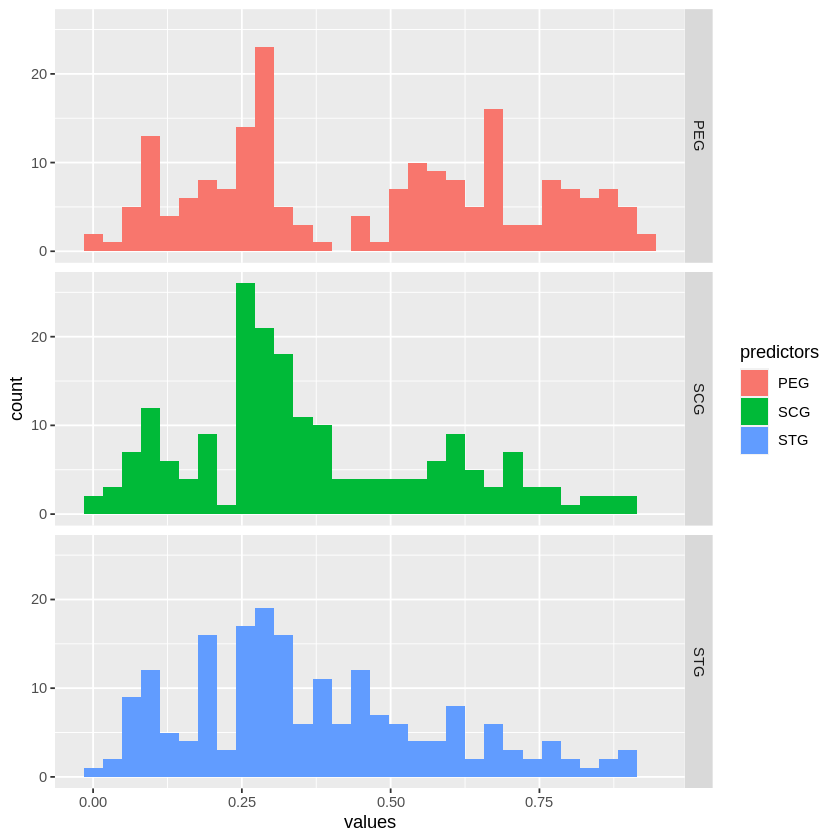

In [7]:
# Distributions of the three predictors 
dist_pred <- user_train_wide |> ggplot(aes(x=values, fill=predictors))+
                                geom_histogram(bins=30)+
                                facet_grid(rows=vars(predictors))
dist_pred

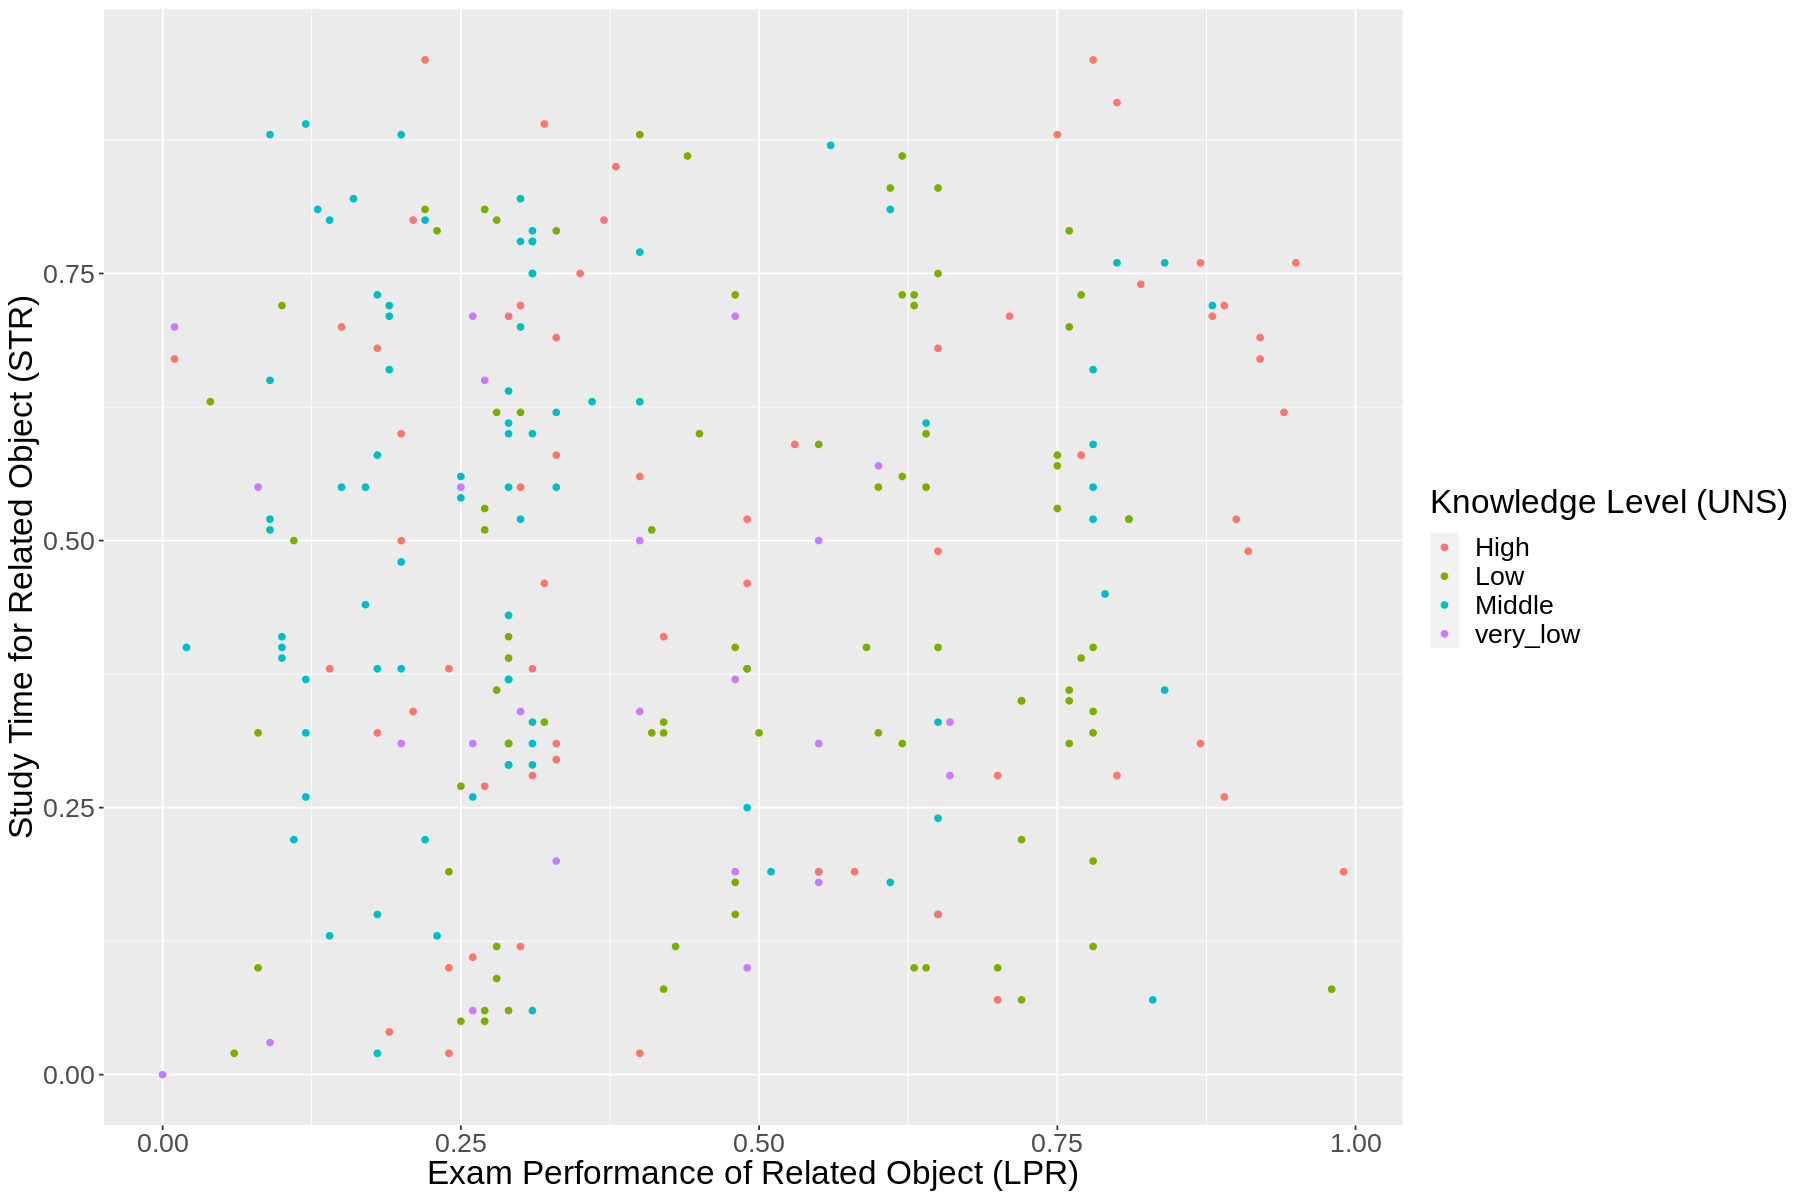

In [8]:
# Scatter plot of STR vs LPR to see if the two variables that we exclude from our predictors
# have some power to predict UNS.
# It seems that they don't have much power to predict UNS,
# which may indicate our decision of excluding these two variables from predictors is correct.

library(repr)
options(repr.plot.width=15, repr.plot.height=10)
rel_point <- users |> ggplot(aes(x=LPR,y=STR,colour=UNS))+
                        geom_point()+
                        labs(x="Exam Performance of Related Object (LPR)", 
                             y="Study Time for Related Object (STR)",
                            colour="Knowledge Level (UNS)")+
                        theme(text=element_text(size=20))
rel_point

**Methods and General steps for data analysis**

1. Define the target value: UNS.

2. Select the variables: STG, SCG, PEG.

3. Split the data into training and test sets.

4. Cross-validation using the vfold_cv function.

4. Create a recipe.

4. Build the k-nearest model with neighbours  = tune() 

6. Create a workflow(), and use the tune_grid function to estimate the classifier accuracy for a range of K values.

8. Plot neighbours vs accuracy estimate to find the best K value.

9. Use the best K to make a new model specification and retrain the classifier.

10. Evaluate the accuracy on the test set.


**Visualization for the results:**

1. Neighbours vs accuracy estimate (scatter plot + line plot) to show chosen K value

2. Bar chart for classes (very low, low, middle, high)  vs. accuracy (counts of incorrect values) to see success of model

3. Three scatter plots, each using two of the three predictors as variables, to see predictors' power of predicting class.

Since we use three predictors to predict results, there is no way to directly visualize the results in a 2-D graph. The best way to illustrate our resluts is by evaluating accuracy and confusion matrix.

**Expected outcomes and significance:**

1.What do you expect to find?

STG, SCG and PEG can predict the UNS of a new student with pretty good accuracy.

2.What impact could such findings have?

Our findings can help employ people. For example, if the people a company needs require some understanding of certain materials, we can evaluate their knowledge level by surveying their study time for the materials, repetition frequencies for the materials and their related exam performances.
Our findings can also help students assess the efficiencies of their study strategies and their ability to comprehend the subject.

3.What future questions could this lead to?

Can more variables such as the method of studying and students’ self evaluation of preparedness increase the accuracy of the classification model?
If we reduce one variable, can we get similar or same results?
